The overall goal is to access the following publicly available datasets and metadata. These are all three-dimensional electron microscopy acquisitions of different specimen:

https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740

https://www.ebi.ac.uk/empiar/EMPIAR-11759/

https://www.epfl.ch/labs/cvlab/data/data-em/

https://openorganelle.janelia.org/datasets/jrc_mus-nacc-2

https://tinyurl.com/hemibrain-ng (download only a random 1000x1000x1000 pixel crop region)

Tasks:

Develop code for downloading these image datasets that are stored in different ways (ideally parallel, multi-threaded) and put the code on GitHub (ideally in a way that we can reproduce it).

Identify and consolidate meta-data entries across these datasets, such as resolution or pixel type (some metadata entries will be available only for some of the datasets), list everything can you extract, find corresponding entries between datasets. Share the consolidated entry table in the GitHub repo, together with a quick summary of how you did it.

Think about how to make these image dataset and metadata available for ingestion by an AI/ML pipeline. The software should be able to provide access to each image in a block-wise manner (e.g. the ML software will request 128x128x128 pixel block at various locations within each dataset). How would you go about designing and implementing such a software? The idea here is not to implement it, but to think it through and outline how you would do it, please create a PDF or similar.

In [1]:
#Setup the environment

! pip install --upgrade s3fs
! pip install --upgrade zarr 
! pip install --upgrade fsspec
! pip install --upgrade quilt3
! pip install --upgrade tensorstore

from multiprocessing.pool import ThreadPool
from multiprocessing import cpu_count
import requests
from PIL import Image
from PIL.TiffTags import TAGS
import s3fs
import fsspec, zarr
import quilt3 as q3
import tensorstore as ts
import os
import time
import numpy as np
import matplotlib.pyplot as plt

! pip install --upgrade ncempy
import ncempy.io as nio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 60.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.11
    Uninstalling botocore-1.38.11:
      Successfully uninstalled botocore-1.38.11
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.4.2
    Uninstalling s3fs-0.4.2:
      Successfully uninstalled s3fs-0.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompati

In [2]:
def download_url(args):
    t0 = time.time()
    url, filename = args[0], args[1]
    try:
        response = requests.get(url)
        with open(filename, mode="wb") as file:
            file.write(response.content)
            print(f"Downloaded file {filename}")
            print(response.status_code)
            return(url, time.time() - t0)
    except Exception as e:
        print('Exception in download_url():', e)  

In [3]:
def download_parallel(args): 
  cpus = cpu_count() 
  results = ThreadPool(cpus - 1).imap_unordered(download_url, args) 
  for result in results: 
    print('url:', result[0], 'time (s):', result[1])

In [4]:
urls = [
# 1.https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740
'https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740#',

#2. https://www.ebi.ac.uk/empiar/EMPIAR-11759/
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0000.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0001.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0002.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0003.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0004.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0005.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0006.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0007.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0008.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0009.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0010.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0011.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0012.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0013.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0014.dm3',
'https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0015.dm3',
#3. https://www.epfl.ch/labs/cvlab/data/data-em/   
"https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif"]

filenames = [
# 1.https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740
'/kaggle/working/Figure_S3B_FIB-SEM_U2OS_20x20x20nm_xy.tif.png',

    
#2. https://www.ebi.ac.uk/empiar/EMPIAR-11759/
'/kaggle/working/F57-8_test1_3VBSED_slice_0000.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0001.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0002.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0003.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0004.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0005.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0006.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0007.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0008.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0009.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0010.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0011.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0012.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0013.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0014.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0015.dm3',
#3. https://www.epfl.ch/labs/cvlab/data/data-em/
'/kaggle/working/volumedata.tif']

inputs=zip(urls, filenames)

In [5]:
# Download the images from dataset 1, 2, and 3 simultaneously

download_parallel(inputs)

Downloaded file /kaggle/working/Figure_S3B_FIB-SEM_U2OS_20x20x20nm_xy.tif.png
200
url: https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740# time (s): 0.07353639602661133
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0001.dm3
200
url: https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0001.dm3 time (s): 1.0038659572601318
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0000.dm3
200
url: https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0000.dm3 time (s): 1.0404384136199951
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0002.dm3
200
url: https://ftp.ebi.ac.uk/empiar/world_availability/11759/data/F57-8_test1_3VBSED_slice_0002.dm3 time (s): 1.0073540210723877
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0003.dm3
200
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0005.dm3
200
Downloaded file /kaggle/working/F57-8_test1_3VBSED_slice_0004.dm3
200
url: h

PNG (1425, 913) RGBA
Max:      255
Min:        0


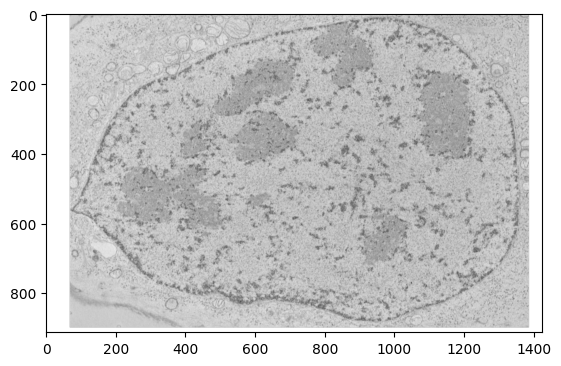

In [6]:
# 1.https://idr.openmicroscopy.org/webclient/img_detail/9846137/?dataset=10740

img = Image.open('/kaggle/working/Figure_S3B_FIB-SEM_U2OS_20x20x20nm_xy.tif.png')
img.load()


print(img.format, img.size, img.mode)
print('Max: {:8d}'.format(np.max(img)))
print('Min: {:8d}'.format(np.min(img)))
plt.imshow(img)
plt.show()

Slice 0
{'filename': 'F57-8_test1_3VBSED_slice_0000.dm3', 'data': array([[107, 109, 106, ...,  89,  92,  94],
       [114, 115, 111, ...,  98, 103, 101],
       [111, 109, 111, ...,  90,  88,  89],
       ...,
       [ 86,  92,  98, ..., 105, 105, 103],
       [ 98, 100,  98, ..., 107, 102, 102],
       [ 81,  87,  94, ..., 110, 105, 103]], dtype=uint8), 'pixelUnit': ['µm', 'µm'], 'pixelSize': [0.00799825, 0.00799825], 'coords': [array([0.00000e+00, 8.00000e-03, 1.60000e-02, ..., 4.39664e+01,
       4.39744e+01, 4.39824e+01]), array([0.00000e+00, 8.00000e-03, 1.60000e-02, ..., 4.39344e+01,
       4.39424e+01, 4.39504e+01])]}
Slice 1
{'filename': 'F57-8_test1_3VBSED_slice_0001.dm3', 'data': array([[116, 115, 109, ...,  89,  92,  95],
       [113, 107, 105, ..., 105, 103, 105],
       [111, 118, 119, ...,  98,  99, 101],
       ...,
       [105, 106, 104, ..., 105, 108, 105],
       [114, 115, 114, ..., 119, 117, 110],
       [105, 109, 110, ..., 116, 118, 116]], dtype=uint8), 'pixelUnit

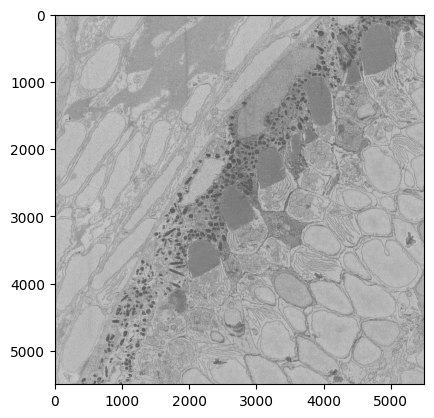

In [7]:
#2. https://www.ebi.ac.uk/empiar/EMPIAR-11759/

filenames = [
'/kaggle/working/F57-8_test1_3VBSED_slice_0000.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0001.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0002.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0003.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0004.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0005.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0006.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0007.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0008.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0009.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0010.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0011.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0012.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0013.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0014.dm3',
'/kaggle/working/F57-8_test1_3VBSED_slice_0015.dm3']

imgs = []
slice = 0

for filename in filenames:
    img = nio.read(filename)
    print (f"Slice {slice}")
    print(img)
    if slice == 0:
        imgs = img['data']
        imgs = imgs[:, :, np.newaxis] 
    else:
        imgs = np.concatenate((imgs, img['data'][:, :, np.newaxis]), axis=2)
    slice+= 1

print(imgs.shape)
print('Max: {:8d}'.format(np.max(imgs)))
print('Min: {:8d}'.format(np.min(imgs)))
plt.imshow(imgs[:, :, 0], cmap='gray')
plt.show()

{'ImageWidth': (2048,), 'ImageLength': (1536,), 'BitsPerSample': (8,), 'Compression': (1,), 'PhotometricInterpretation': (1,), 'PageNumber': (0, 1065), 'StripOffsets': (8, 8200, 16392, 24584, 32776, 40968, 49160, 57352, 65544, 73736, 81928, 90120, 98312, 106504, 114696, 122888, 131080, 139272, 147464, 155656, 163848, 172040, 180232, 188424, 196616, 204808, 213000, 221192, 229384, 237576, 245768, 253960, 262152, 270344, 278536, 286728, 294920, 303112, 311304, 319496, 327688, 335880, 344072, 352264, 360456, 368648, 376840, 385032, 393224, 401416, 409608, 417800, 425992, 434184, 442376, 450568, 458760, 466952, 475144, 483336, 491528, 499720, 507912, 516104, 524296, 532488, 540680, 548872, 557064, 565256, 573448, 581640, 589832, 598024, 606216, 614408, 622600, 630792, 638984, 647176, 655368, 663560, 671752, 679944, 688136, 696328, 704520, 712712, 720904, 729096, 737288, 745480, 753672, 761864, 770056, 778248, 786440, 794632, 802824, 811016, 819208, 827400, 835592, 843784, 851976, 860168, 8

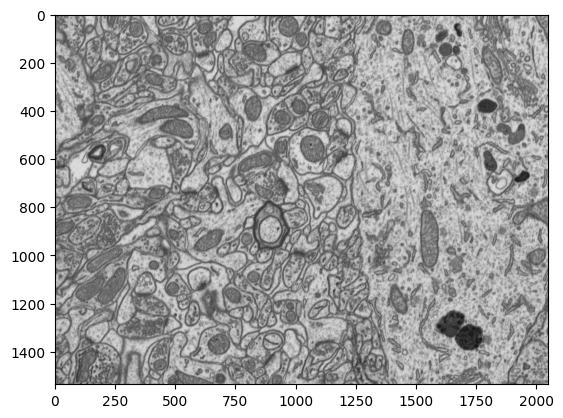

In [8]:
#3. https://www.epfl.ch/labs/cvlab/data/data-em/

from PIL.TiffTags import TAGS
with Image.open('/kaggle/working/volumedata.tif') as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}
print(meta_dict)
img = Image.open('/kaggle/working/volumedata.tif')
print('Max: {:8d}'.format(np.max(img)))
print('Min: {:8d}'.format(np.min(img)))
plt.imshow(img, cmap='gray')
plt.show()

In [9]:
#4. https://openorganelle.janelia.org/datasets/jrc_mus-nacc-2

b = q3.Bucket("s3://janelia-cosem-datasets")

b.ls("jrc_mus-nacc-2/")

b.fetch("jrc_mus-nacc-2/", "/kaggle/working/jrc_mus-nacc-2/")

100%|██████████| 4.65G/4.65G [04:57<00:00, 15.6MB/s]   


Type               : Array
Zarr format        : 2
Data type          : int16
Shape              : (564, 2520, 2596)
Chunk shape        : (64, 64, 64)
Order              : C
Read-only          : True
Store type         : FsspecStore
Filters            : ()
Compressors        : (Zstd(level=1),)
No. bytes          : 7379285760 (6.9G)
No. bytes stored   : 4073580810
Storage ratio      : 1.8
Chunks Initialized : 14760
Max:     1697
Min:        0


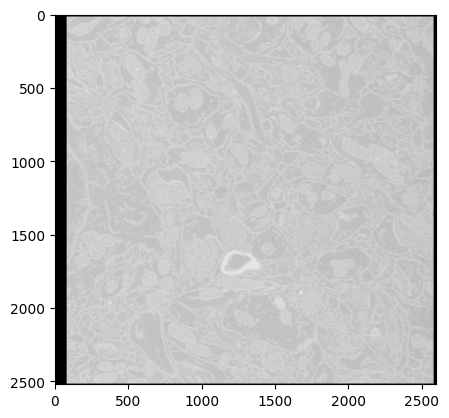

In [10]:
#4. https://openorganelle.janelia.org/datasets/jrc_mus-nacc-2

store = zarr.storage.FsspecStore.from_url(
   's3://janelia-cosem-datasets/jrc_mus-nacc-2/jrc_mus-nacc-2.zarr/recon-2/em/fibsem-int16/',
   read_only=True,
   storage_options={'anon': True}
)
root=zarr.open_group(store=store, mode='r')
root.tree()
img = root['s0'] 
print(img.info_complete())
print('Max: {:8d}'.format(np.max(img)))
print('Min: {:8d}'.format(np.min(img)))
plt.imshow(img[282,:,:], cmap='gray')
plt.show()

E0616 07:08:43.740970     153 google_auth_provider.cc:188] Could not find the credentials file in the standard gcloud location [/content/.config/application_default_credentials.json]. You may specify a credentials file using $GOOGLE_APPLICATION_CREDENTIALS, or to use Google application default credentials, run: gcloud auth application-default login


TensorStore({
  'context': {
    'cache_pool': {'total_bytes_limit': 1000000000},
    'data_copy_concurrency': {},
    'gcs_request_concurrency': {},
    'gcs_request_retries': {},
    'gcs_user_project': {},
  },
  'driver': 'neuroglancer_precomputed',
  'dtype': 'uint64',
  'kvstore': {
    'bucket': 'neuroglancer-janelia-flyem-hemibrain',
    'driver': 'gcs',
    'path': 'v1.0/segmentation/',
  },
  'multiscale_metadata': {'num_channels': 1, 'type': 'segmentation'},
  'scale_index': 0,
  'scale_metadata': {
    'chunk_size': [64, 64, 64],
    'compressed_segmentation_block_size': [8, 8, 8],
    'encoding': 'compressed_segmentation',
    'key': '8.0x8.0x8.0',
    'resolution': [8.0, 8.0, 8.0],
    'sharding': {
      '@type': 'neuroglancer_uint64_sharded_v1',
      'data_encoding': 'gzip',
      'hash': 'identity',
      'minishard_bits': 6,
      'minishard_index_encoding': 'gzip',
      'preshift_bits': 9,
      'shard_bits': 15,
    },
    'size': [34432, 39552, 41408],
    'voxel

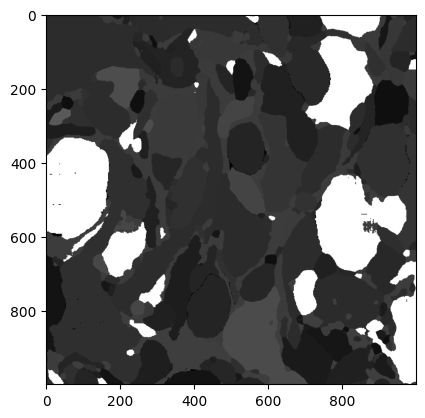

In [11]:
5. #https://tinyurl.com/hemibrain-ng (download only a random 1000x1000x1000 pixel crop region)

context = ts.Context({'cache_pool': {'total_bytes_limit': 1000000000}})

em_8nm = ts.open({
    'driver': 'neuroglancer_precomputed',
    'kvstore': 'gs://neuroglancer-janelia-flyem-hemibrain/v1.0/segmentation'},
    read=True, context=context).result()[ts.d['channel'][0]]

# select a random 1000x1000x1000 pixel crop region
print(em_8nm)
img_cutout_8nm = em_8nm[18888:18888+1000, 18888:18888+1000, 18888:18888+1000].read().result().transpose()
#img_cutout_8nm[:,:,512] 
print('Max: {:8d}'.format(np.max(img_cutout_8nm)))
print('Min: {:8d}'.format(np.min(img_cutout_8nm)))

plt.imshow(img_cutout_8nm[:,:,512], cmap='gray')